# **Deep Hedging**
# Buchkov Viacheslav

In [1]:
!pip install deep_hedging

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cache

In [2]:
from pathlib import Path

from deep_hedging import ExperimentConfig, EuropeanCall, seed_everything

from deep_hedging.dl import Trainer, Assessor
from deep_hedging.dl.models import LSTMHedger
from deep_hedging.dl.baselines import BaselineEuropeanCall

RANDOM_SEED = 12

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


In [3]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

PATH = Path("/content/gdrive/MyDrive/")

Mounted at /content/gdrive


In [4]:
config = ExperimentConfig(
    RANDOM_SEED=RANDOM_SEED, DATA_ROOT=PATH, OUTPUT_ROOT=Path("."), DATA_FILENAME="2024"
)
seed_everything(RANDOM_SEED)

config.DEVICE

device(type='cuda')

In [5]:
print(config)

ExperimentConfig(N_DAYS=5, REBAL_FREQ='30 min', VAR_QUANTILE=0.05, TEST_SIZE=0.1, RANDOM_SEED=12, DATA_ROOT=PosixPath('/content/gdrive/MyDrive'), OUTPUT_ROOT=PosixPath('.'), DATA_FILENAME='2024', LAYER_NORM=False, USE_TIME_DIFF=True, USE_SPOT_START=True, N_EPOCHS=20, N_STEPS_RL_TRAIN=1000000, LR=0.01, BATCH_SIZE=32, NUM_LAYERS=3, HIDDEN_DIM=32, EMBED_MAX_DIM=128, OPTIMIZER=<class 'torch.optim.adam.Adam'>, NUM_WORKERS=2)


## Run.

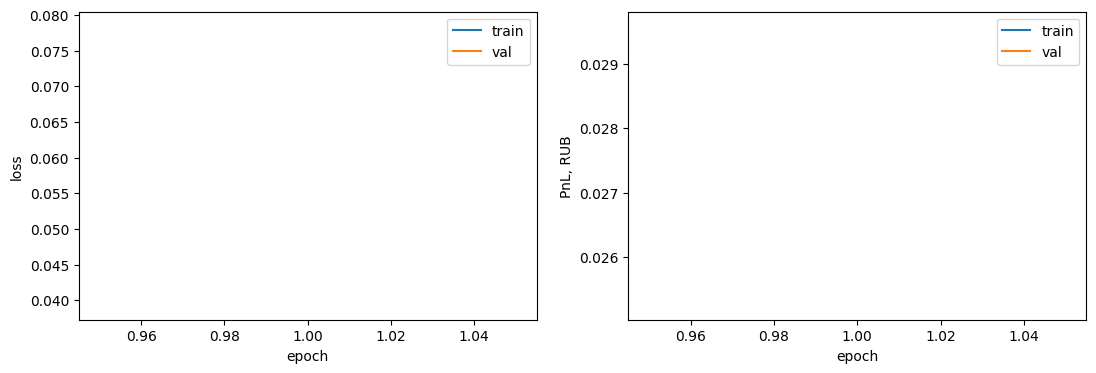

In [6]:
N_EPOCHS = 1
config.REBAL_FREQ = "30 min"

trainer = Trainer(model_cls=LSTMHedger, instrument_cls=EuropeanCall, config=config)
trainer.run(N_EPOCHS)

## Baseline check.

Average weight = 0.5034013390541077, Weights = [0.5034013390541077; 0.5034013390541077]
Means: model = 0.945550, baseline = 1.058484
Stds: model = 0.599799, baseline = 0.552206
VaRs 5%: model = -0.161007, baseline = -0.384472
T-stat = -15.396996


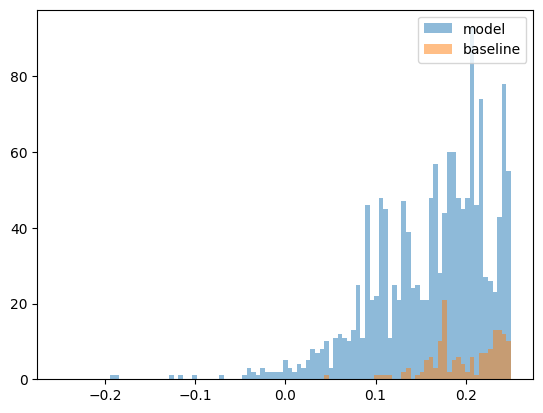

In [7]:
from deep_hedging.dl import Assessor

assessor = Assessor(
    model=trainer.hedger,
    baseline=BaselineEuropeanCall(dt=trainer.dt).to(config.DEVICE),
    test_loader=trainer.test_loader,
)
assessor.run()

In [8]:
trainer.save(config.OUTPUT_ROOT)